In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import (LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, ElasticNetCV, LassoCV, RidgeCV)
from sklearn.metrics import (mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score, accuracy_score)
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score, train_test_split, LeaveOneOut, GridSearchCV)
from sklearn import linear_model


In [2]:
train_df = pd.read_csv("trainhp.csv")
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test_df = pd.read_csv("testhp.csv")

## Altering data for easier Kaggle submission
Adapted from the Kaggle top 10% AMES article: https://www.kaggle.com/code/anupjana/top-10-ames-house-pricing-stacked-regression/notebook

In [4]:
train_df_proc = train_df.copy()
test_df_proc = test_df.copy()

# Save the 'Id' column for submission purposes
train_ID = train_df_proc['Id']
test_ID = test_df_proc['Id']

# Drop the 'Id' column since it's unnecessary for the prediction process
train_df_proc.drop("Id", axis=1, inplace=True)
test_df_proc.drop("Id", axis=1, inplace=True)

# Further EDA/General Data Visuals 

In [5]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The median SalePrice is $163000. The mean is $180921.20

In [7]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
test_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Distribution of 'SalePrice'

Text(0.5, 1.0, 'Distribution of Sale Prices')

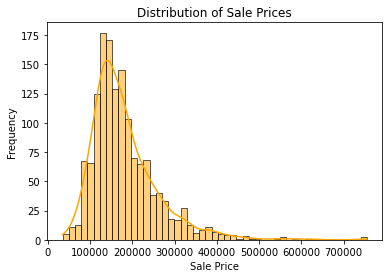

In [10]:
sns.histplot(data=train_df_proc, kde=True, x='SalePrice', color='orange')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of Sale Prices')

### Examining log transformation distribution

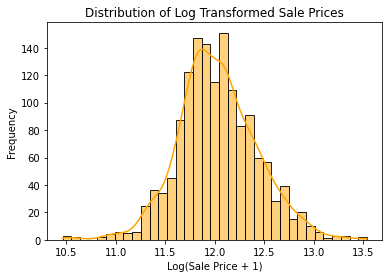

In [11]:
# Applying log transformation on 'SalePrice'
train_df_proc['LogSalePrice'] = np.log1p(train_df_proc['SalePrice'])

sns.histplot(data=train_df_proc, kde=True, x='LogSalePrice', color='orange')
plt.xlabel('Log(Sale Price + 1)')
plt.ylabel('Frequency')
plt.title('Distribution of Log Transformed Sale Prices')
plt.show()


In [12]:
saleprice_kurtosis = train_df_proc['SalePrice'].kurt()
log_saleprice_kurtosis = train_df_proc['LogSalePrice'].kurt()

print(f"Kurtosis of SalePrice: {saleprice_kurtosis}")
print(f"Kurtosis of LogSalePrice: {log_saleprice_kurtosis}")

Kurtosis of SalePrice: 6.536281860064529
Kurtosis of LogSalePrice: 0.809519155707878


- Original kurtosis value of 6.54 indicates that the distribution of the original SalePrice has heavier tails and a sharper peak compared to a normal distribution.
- Log-transformed kurtosis value of 0.81 is closer to 3, which is the kurtosis of a standard normal distribution. This suggests the log-transformed data is more normally distributed, with tails and a peak closer to that of a normal distribution.

## Evaluate Missing data 
This part is largely taken from the previous Assignment 1 & 2 EDA

In [13]:
# Examine missing values in our data by column
mv_count = train_df_proc.isnull().sum()
mv_percentage = (train_df_proc.isnull().sum() * 100 / len(train_df_proc)).round(2)
column_type = train_df_proc.dtypes

mv_summary = pd.DataFrame({
    'Missing Count': mv_count,
    'Percentage Missing': mv_percentage,
    'Column Type': column_type
})

mv_summary_ascending = mv_summary[mv_count > 0].sort_values('Percentage Missing', ascending=False)

print("Summary of Missing Values:")
print(mv_summary_ascending)

Summary of Missing Values:
              Missing Count  Percentage Missing Column Type
PoolQC                 1453               99.52      object
MiscFeature            1406               96.30      object
Alley                  1369               93.77      object
Fence                  1179               80.75      object
FireplaceQu             690               47.26      object
LotFrontage             259               17.74     float64
GarageType               81                5.55      object
GarageYrBlt              81                5.55     float64
GarageFinish             81                5.55      object
GarageQual               81                5.55      object
GarageCond               81                5.55      object
BsmtExposure             38                2.60      object
BsmtFinType2             38                2.60      object
BsmtFinType1             37                2.53      object
BsmtCond                 37                2.53      object
BsmtQual     

In [14]:
# NA columns -> None
na_columns = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
              'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']

for col in na_columns:
    fill_value = 'None'
    train_df_proc[col].fillna(fill_value, inplace=True)
    test_df_proc[col].fillna(fill_value, inplace=True)

# 'LotFrontage'fill using median within respective 'Neighborhood' group
neighborhood_medians = train_df_proc.groupby('Neighborhood')['LotFrontage'].median()

for neighborhood, median in neighborhood_medians.items():
    condition = (train_df_proc['Neighborhood'] == neighborhood)
    train_df_proc.loc[condition, 'LotFrontage'] = train_df_proc.loc[condition, 'LotFrontage'].fillna(median)
    
    condition_test = (test_df_proc['Neighborhood'] == neighborhood)
    test_df_proc.loc[condition_test, 'LotFrontage'] = test_df_proc.loc[condition_test, 'LotFrontage'].fillna(median)

# 'GarageYrBlt' fill with 'YearBuilt' value
train_df_proc['GarageYrBlt'].fillna(train_df_proc['YearBuilt'], inplace=True)
test_df_proc['GarageYrBlt'].fillna(test_df_proc['YearBuilt'], inplace=True)

# Summarize missing values
null_count = train_df_proc.isnull().sum()
null_percentage = (train_df_proc.isnull().sum() * 100 / len(train_df_proc)).round(2)
column_type = train_df_proc.dtypes

null_summary = pd.DataFrame({
    'Missing Count': null_count,
    'Percentage Missing': null_percentage,
    'Column Type': column_type
})

null_summary_only_missing = null_summary[null_count > 0].sort_values('Percentage Missing', ascending=False)

print("Summary of Missing Values:")
print(null_summary_only_missing)


Summary of Missing Values:
            Missing Count  Percentage Missing Column Type
MasVnrArea              8                0.55     float64
Electrical              1                0.07      object


### Impute MasVnrArea with median

In [15]:
median_masvnr = train_df_proc['MasVnrArea'].median()
train_df_proc['MasVnrArea'].fillna(median_masvnr, inplace=True)
test_df_proc['MasVnrArea'].fillna(median_masvnr, inplace=True)

### Drop row with missing value 'Electrical'
Similarly to last 2 assignments, deemed a single missing value could be dropped instead of filled

In [16]:
train_df_proc.dropna(subset=['Electrical'], inplace=True)

### Verify that there are no more columns with missing values

In [17]:
null_count = train_df_proc.isnull().sum()
null_percentage = (train_df_proc.isnull().sum() * 100 / len(train_df_proc)).round(2)
column_type = train_df_proc.dtypes

null_summary = pd.DataFrame({
    'Missing Count': null_count,
    'Percentage Missing': null_percentage,
    'Column Type': column_type
})

null_summary_only_missing = null_summary[null_count > 0].sort_values('Percentage Missing', ascending=False)

print("Summary of Missing Values:")
print(null_summary_only_missing)

Summary of Missing Values:
Empty DataFrame
Columns: [Missing Count, Percentage Missing, Column Type]
Index: []


### No columns with missing values

# Concatenating

In [18]:
ntrain = train_df_proc.shape[0]
ntest = test_df_proc.shape[0]

# Extract the SalePrice values from the training set
y_train = train_df_proc.SalePrice.values

# Concatenate the train and test datasets
all_df = pd.concat((train_df_proc, test_df_proc)).reset_index(drop=True)

# Drop the SalePrice column 
all_df.drop(['SalePrice'], axis=1, inplace=True)

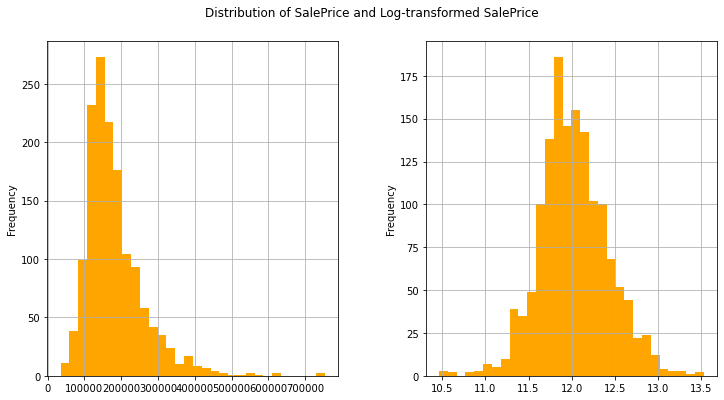

In [19]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)

prices = pd.DataFrame({
    "SalePrice": y_train,
    "Log-Transformed SalePrice": np.log1p(y_train)
})

# Plot histograms
ax = prices.hist(bins=30, color="orange")
plt.suptitle('Distribution of SalePrice and Log-transformed SalePrice')
for axis in ax.flatten():
    axis.set_title("")
    axis.set_xlabel(axis.get_title())
    axis.set_ylabel("Frequency")
plt.subplots_adjust(top=0.90)
plt.show()

There is less skewness after log transformation

#### Log transforming skewed numeric features

In [20]:
y_train = np.log1p(y_train)
numeric_feats = all_df.dtypes[all_df.dtypes != "object"].index
skewed_feats = all_df[numeric_feats].apply(lambda x: skew(x.dropna()))

# Filter to skewness greater than 0.75
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats_cols = skewed_feats.index

# Log-transform selected features
all_df[skewed_feats_cols] = np.log1p(all_df[skewed_feats_cols])


#### Convert catagorical variables 

In [21]:
all_df = pd.get_dummies(all_df)

# Fill missing values with column mean
all_df = all_df.fillna(all_df.mean())

In [22]:
X_train = all_df[:ntrain]
X_test = all_df[ntrain:]
y = y_train

In [23]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# The Mistake

In [ ]:
# Drop the 'Log_SalePrice' from the training data
X_train = X_train.drop(['Log_SalePrice'], axis=1)

# If 'Log_SalePrice' exists in the test data, remove it there too
if 'Log_SalePrice' in X_test.columns:
    X_test = X_test.drop(['Log_SalePrice'], axis=1)

In [30]:
if 'LogSalePrice' in X_train.columns:
    X_train = X_train.drop(['LogSalePrice'], axis=1)

if 'LogSalePrice' in X_test.columns:
    X_test = X_test.drop(['LogSalePrice'], axis=1)

#### I had completed all of my models originally and was gettign highly competitive RMSE scores. Yet, when I uploaded my .csv files to Kaggle, it output very poor scores. I should've noticed earlier that these scores were indicative of overfitting (I had thought so, but didn't know how). 

# Lasso Model

In [31]:
from sklearn.linear_model import LassoCV

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
print("Lasso Model Score:", model_lasso.score(X_train, y_train))

Lasso Model Score: 0.9307247602813842


In [32]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse.mean())

print("Lasso RMSE:", rmse_cv(model_lasso))

Lasso RMSE: 0.12279697884243948


In [33]:
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [34]:
submission = pd.DataFrame({"id": test_ID, "SalePrice": lasso_preds})
submission.to_csv("lasso_submission.csv", index=False)

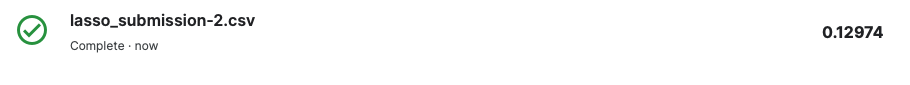

#### Finding the weights used in the Lasso model 
This was how I identified the primary overfitting problem

In [35]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

feature_names = X_train.columns
coefficients = model_lasso.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
selected_features = coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)

print(selected_features)

                   Feature  Coefficient
15               GrLivArea     0.414003
86    Neighborhood_StoneBr     0.111600
70    Neighborhood_Crawfor     0.105437
79    Neighborhood_NoRidge     0.083851
240         Functional_Typ     0.072989
..                     ...          ...
296  SaleCondition_Abnorml    -0.048846
71    Neighborhood_Edwards    -0.052462
102        Condition2_PosN    -0.197481
36        MSZoning_C (all)    -0.291434
125       RoofMatl_ClyTile    -0.691998

[107 rows x 2 columns]


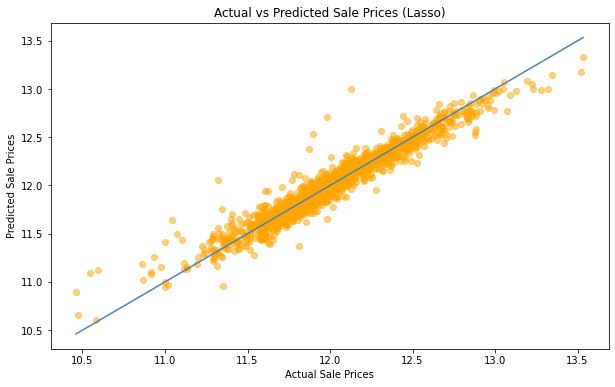

In [36]:
import matplotlib.pyplot as plt

# Predicted values
y_train_pred = model_lasso.predict(X_train)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5, color = 'orange')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='steelblue') # Identity line
plt.xlabel('Actual Sale Prices')
plt.ylabel('Predicted Sale Prices')
plt.title('Actual vs Predicted Sale Prices (Lasso)')
plt.show()


# Ridge Model

In [41]:
# Define a range of alphas for Ridge regression
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
ridge_rmses = []
# Create the RidgeCV model
model_ridge = RidgeCV(alphas=alphas, cv=5).fit(X_train, y_train)

In [42]:
# Using the rmse_cv function we defined earlier
ridge_rmse = rmse_cv(model_ridge).mean()
print(f"Ridge RMSE: {ridge_rmse}")
print(f"Optimal alpha for Ridge: {model_ridge.alpha_}")


Ridge RMSE: 0.1273628541222791
Optimal alpha for Ridge: 10.0


In [43]:
ridge_preds = np.expm1(model_ridge.predict(X_test))


In [44]:
submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": ridge_preds
})
submission.to_csv("ridge_submission.csv", index=False)


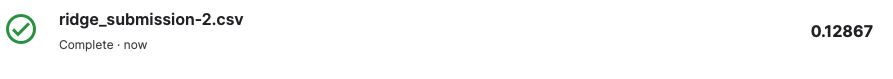

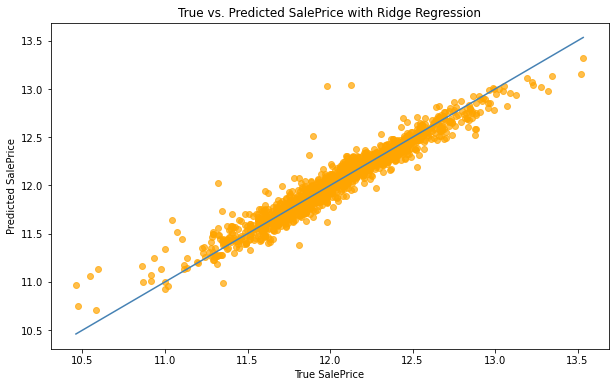

In [45]:
# Train the Ridge model with the optimal alpha
model_ridge_optimal = Ridge(alpha=model_ridge.alpha_).fit(X_train, y_train)

# Predicted SalePrice values for the training set
predicted_values = model_ridge_optimal.predict(X_train)

# Plotting the true vs. predicted values
plt.figure(figsize=(10,6))
plt.scatter(y_train, predicted_values, alpha=0.7, color = 'orange')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='steelblue')  # identity line
plt.xlabel("True SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("True vs. Predicted SalePrice with Ridge Regression")
plt.show()


# ElasticNet

In [51]:
# Find optimal alpha and l1_ratio using ElasticNetCV
enet_cv = ElasticNetCV(alphas=None, cv=5, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], max_iter=50000)
enet_cv.fit(X_train, y_train)

optimal_alpha = enet_cv.alpha_
optimal_l1_ratio = enet_cv.l1_ratio_


In [52]:
# Train the ElasticNet model
model_enet = ElasticNet(alpha=optimal_alpha, l1_ratio=optimal_l1_ratio, max_iter=50000)
model_enet.fit(X_train, y_train)


ElasticNet(alpha=0.05558876886395101, l1_ratio=1.0, max_iter=50000)

In [53]:
rmse_enet = rmse_cv(model_enet).mean()
print(f"RMSE for ElasticNet: {rmse_enet}")


RMSE for ElasticNet: 0.20122467369077116


In [54]:
enet_preds = model_enet.predict(X_test)

final_predictions = np.expm1(enet_preds)

submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": final_predictions
})

submission.to_csv("elastic_net_submission.csv", index=False)


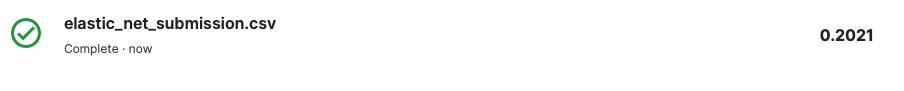

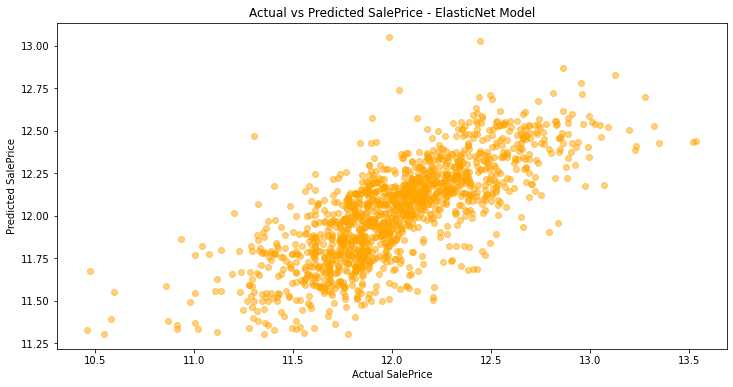

In [56]:
enet_model = ElasticNet()
enet_model.fit(X_train, y_train)
predicted = enet_model.predict(X_train)
plt.scatter(y_train, predicted, alpha=0.5, color = 'orange')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice - ElasticNet Model")
plt.show()


### Hyperparameter tuning

In [57]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}


In [58]:
enet_model = ElasticNet(max_iter=50000)
grid_search = GridSearchCV(enet_model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=50000),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [59]:
best_params = grid_search.best_params_
print(f"Optimal parameters are: {best_params}")


Optimal parameters are: {'alpha': 0.001, 'l1_ratio': 0.5}


In [60]:
best_enet_model = grid_search.best_estimator_
rmse_best_enet = rmse_cv(best_enet_model).mean()
print(f"RMSE for ElasticNet with optimal hyperparameters: {rmse_best_enet}")


RMSE for ElasticNet with optimal hyperparameters: 0.12297767204350811


In [61]:
best_enet_preds = best_enet_model.predict(X_test)

final_predictions = np.expm1(best_enet_preds)

submission = pd.DataFrame({
    "Id": test_ID,
    "SalePrice": final_predictions
})

submission.to_csv("elastic_net_optimal_submission.csv", index=False)


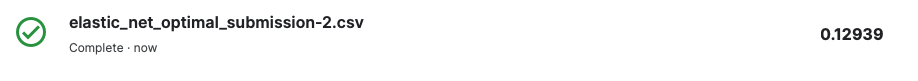

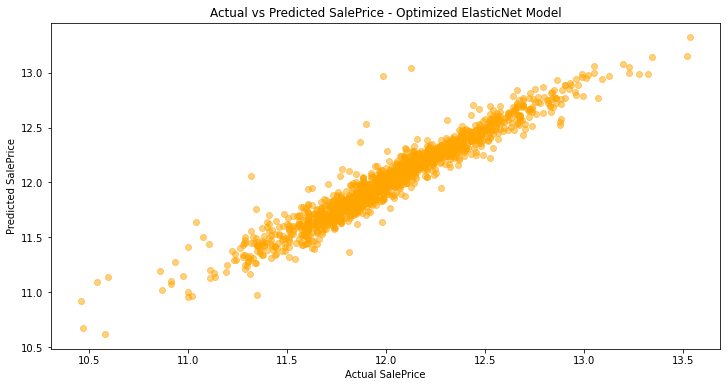

In [62]:
best_enet_model.fit(X_train, y_train)
optimized_predicted = best_enet_model.predict(X_train)
plt.scatter(y_train, optimized_predicted, alpha=0.5, color = 'orange')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice - Optimized ElasticNet Model")
plt.show()
